## Remapping between curvilinear grids using xESMF with land-sea masks

Different algorithms are available:

Bilinear and conservative (need corners) should be the most commonly used methods. They are both monotonic (i.e. will not create new maximum/minimum).
Nearest neighbour methods, either source to destination (s2d) or destination to source (d2s), could be useful in special cases. Keep in mind that d2s is highly non-monotonic.
Patch is ESMF's unique method, producing highly smooth results but quite slow.

Detailed explanations are available on ESMPy documentation (https://xesmf.readthedocs.io/en/latest/why.html)

### Choose kernel gloenv_py3.10

## Preparation


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import numpy as np
import math
import xarray as xr
import xesmf as xe
import pandas as pd
import time as t

In [2]:
begin = t.time()

## Remapping method

In [3]:
method_list = [
    "bilinear",
    "nearest_s2d",
    "nearest_d2s",
    "patch",
]
method=method_list[0]
print("Remapping :"+method)

Remapping :bilinear


## Path to data and names

In [4]:
dir_in="/data/scratch/globc/dcom/CMIP6_TOOLS/xESMF_Interpolation/"
dir_out="/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/"

grids="erst"
gridt="nemo"

# File to remap:
filein="sst_1m_ERSSTv5_185401-202112.nc"
varName="sst"
# Remapped data in file fileout
fileout="sst_1m_"+grids+"_to_"+gridt+"_"+method+"_msk_185401-202112.nc"

data_source="grid_msk_area_"+grids+".nc"    
data_target="grid_msk_area_"+gridt+".nc"    

grdslatname=grids+"_lat"
grdslonname=grids+"_lon"
grdsclaname=grids+"_cla"
grdscloname=grids+"_clo"
msksname=grids+"_msk"
areasname=grids+"_srf"

grdtlatname=gridt+"_lat"
grdtlonname=gridt+"_lon"
grdtclaname=gridt+"_cla"
grdtcloname=gridt+"_clo"
msktname=gridt+"_msk"
areatname=gridt+"_srf"

## Read the source grid 


In [5]:
source_var_grid=[grdslatname,grdslonname]
source_var_mask=[msksname]
source_var_area=[areasname]
# Open the file(s) and read the data (put in ds_source_grid)
with xr.open_dataset(dir_in+data_source) as ds_source_grid:
    lons=ds_source_grid[grdslonname][:,:]  # xarray object
    #lons=ds_source_grid[grdslonname].data # numpy array
    lats=ds_source_grid[grdslatname][:,:] 
    masks=ds_source_grid[msksname][:,:]
    
ndim_s = lons.shape ; y_s = ndim_s[0]; x_s= ndim_s[1];
print("x_s =",x_s)
print("y_s =",y_s)
ys_new=y_s-1
xs_new=x_s-1

x_s = 180
y_s = 89


In [6]:
#print(f'lons {lons[0,0]:.2f}')

## Read the target grid

In [7]:
target_var_grid=[grdtlatname,grdtlonname]
target_var_mask=[msktname]
target_var_area=[areatname]
# Open the file(s) and read the data (put in ds_target_grid)
with xr.open_dataset(dir_in+data_target) as ds_target_grid:
    lont=ds_target_grid[grdtlonname][:,:]  # xarray object
    #lont=ds_target_grid[grdtlonname].data # numpy array
    latt=ds_target_grid[grdtlatname][:,:]
    maskt=ds_target_grid[msktname][:,:]
    
ndim_t = lont.shape ; y_t = ndim_t[0]; x_t= ndim_t[1];
print("x_t =",x_t)
print("y_t =",y_t)

x_t = 362
y_t = 294


## Create an analytical field that is widely used in regridding benchmarks.

### Create a dataset with analytical function and mask

In [8]:
afs_in_msks = xr.Dataset(dict(lat=(('y_s', 'x_s'), lats.values), 
                              lon=(('y_s', 'x_s'), lons.values),
                              mask=(('y_s', 'x_s'), masks.values))
                        )

afs_in_msks.lat.attrs = dict(standard_name='latitude', long_name='latitude', units='degrees_north')
afs_in_msks.lon.attrs = dict(standard_name='longitude', long_name='longitude', units='degrees_east')

afs_in_msks.coords['lat'] = afs_in_msks.lat
afs_in_msks.coords['lon'] = afs_in_msks.lon

afs_in_msks["mask"] = afs_in_msks.mask
afs_in_msks["mask"] = xr.where(afs_in_msks.mask == 1., 0, 1)

afs_in_msks["anafunc_s"] = xe.data.wave_smooth(afs_in_msks["lon"], afs_in_msks["lat"])
afs_in_msks["anafunc_s"] = xr.where(afs_in_msks.mask == 0, float("NaN"), afs_in_msks["anafunc_s"])

aft_out_mskt = xr.Dataset(dict(lat=(('y_t', 'x_t'), latt.values), 
                              lon=(('y_t', 'x_t'), lont.values),
                              mask=(('y_t', 'x_t'), maskt.values),
                              error=(('y_t', 'x_t'), maskt.values))
                        )

aft_out_mskt.lat.attrs = dict(standard_name='latitude', long_name='latitude', units='degrees_north')
aft_out_mskt.lon.attrs = dict(standard_name='longitude', long_name='longitude', units='degrees_east')

aft_out_mskt.coords['lat'] = aft_out_mskt.lat
aft_out_mskt.coords['lon'] = aft_out_mskt.lon
                         
aft_out_mskt["mask"] = aft_out_mskt.mask
aft_out_mskt["mask"] = xr.where(aft_out_mskt.mask == 1., 0, 1)

aft_out_mskt["anafunc_t"] = xe.data.wave_smooth(aft_out_mskt["lon"], aft_out_mskt["lat"])  
aft_out_mskt["anafunc_t"] = xr.where(aft_out_mskt.mask == 0, float("NaN"), aft_out_mskt["anafunc_t"])

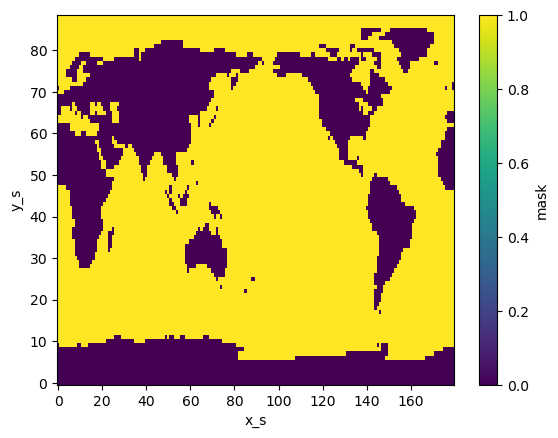

In [9]:
afs_in_msks["mask"].plot()

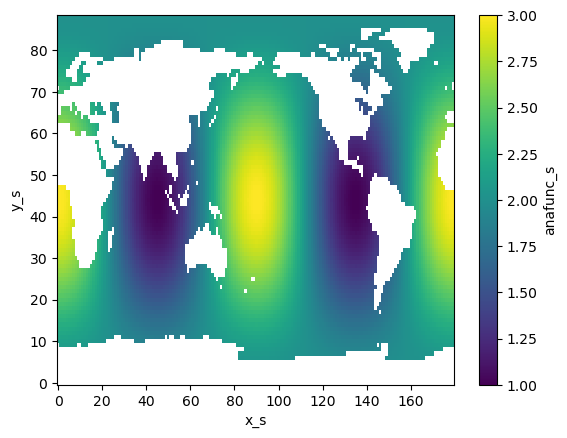

In [10]:
#fig = plt.figure(figsize=(12, 6))
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines()
afs_in_msks["anafunc_s"].plot()

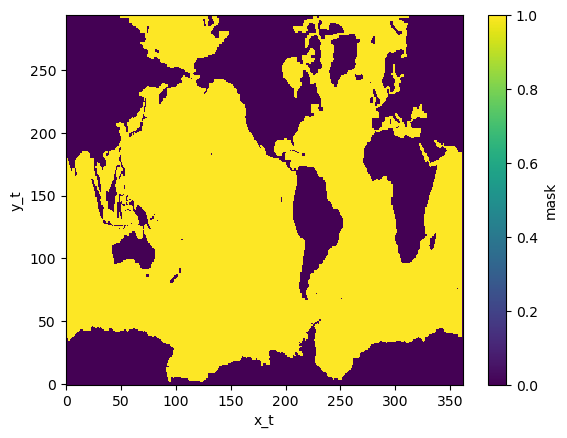

In [11]:
aft_out_mskt["mask"].plot()

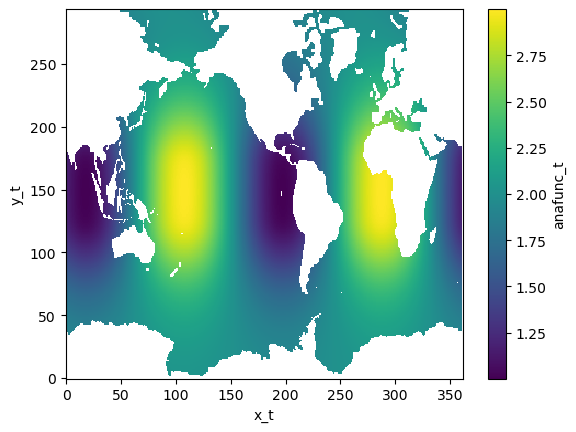

In [12]:
aft_out_mskt["anafunc_t"].plot()

In [13]:
end = t.time()
print('Runtime for preparing the data is', '{0:.1f}'.format(end - begin), 's')

Runtime for preparing the data is 1.3 s


## Remapping and error of interpolation : fields masked  
### We first create the remapping weights (saved automatically by xESMF into a NetCDF file)

In [14]:
begin = t.time()

In [15]:
regridder = xe.Regridder(afs_in_msks, aft_out_mskt, method=method, periodic=True, extrap_method="nearest_s2d")
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_89x180_294x362_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (89, 180) 
Output grid shape:          (294, 362) 
Periodic in longitude?      True

In [16]:
end = t.time()
print('Runtime to calculate the weights is', '{0:.1f}'.format(end - begin), 's')

Runtime to calculate the weights is 1.7 s


### Then we use the weights to calculate the analytical function remapped on the target grid

In [17]:
begin = t.time()

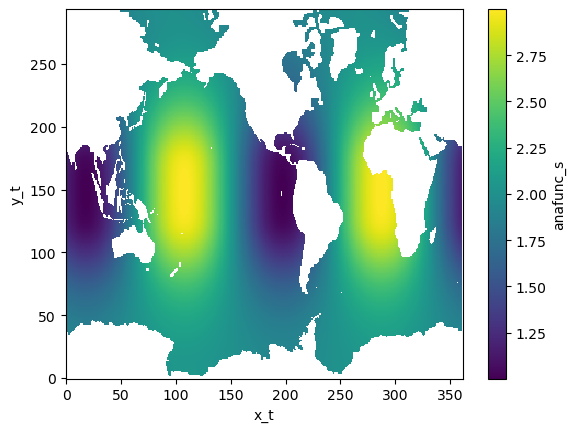

In [18]:
fs_out_msks = regridder(afs_in_msks)
fs_out_msks["anafunc_s"].plot()

### Calculate the error of interpolation on the target non masked points

In [19]:
aft_out_mskt["error"] = abs(((aft_out_mskt["anafunc_t"] - fs_out_msks["anafunc_s"])/fs_out_msks["anafunc_s"]))*100

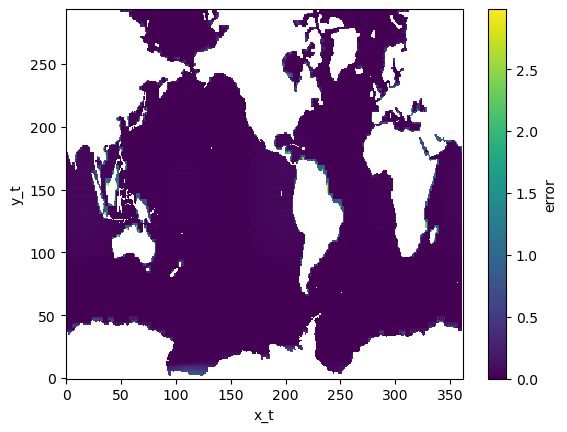

In [20]:
aft_out_mskt["error"].plot()

In [21]:
end = t.time()
print('Runtime to apply the weights plot the remapping field and calculte error is', '{0:.1f}'.format(end - begin), 's')

Runtime to apply the weights plot the remapping field and calculte error is 1.4 s


## Remap data contained in file filein

In [22]:
begin = t.time()

In [23]:
# Open the file(s) and read the data (put in ds_source_file)
with xr.open_dataset(dir_in+filein) as ds_source_file:
    dfs=ds_source_file[varName][:,::-1,:]  #xarray object
    times=ds_source_file['time'][:]
ndim_s = times.shape ; time = ndim_s[0]
print("Time =",time)

Time = 2016


In [24]:
dfs

<xarray.DataArray 'sst' (time: 2016, lat: 89, lon: 180)>
[32296320 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

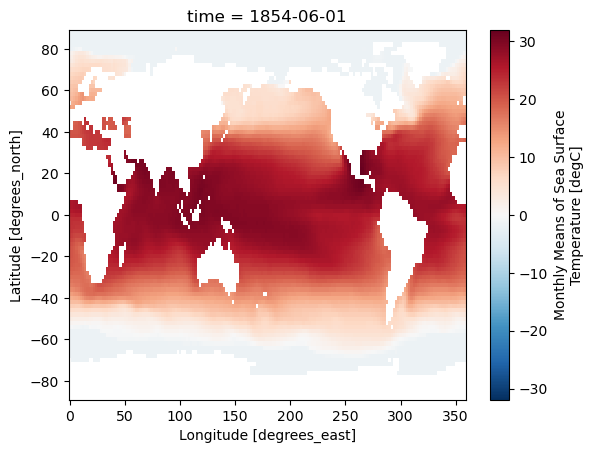

In [25]:
dfs.isel(time=5).plot()

In [26]:
dfs_in_msks = xr.Dataset(dict(lat=(('y_s', 'x_s'), lats.values), 
                         lon=(('y_s', 'x_s'), lons.values),
                         time=(('time'), times.values),
                         mask=(('y_s', 'x_s'), masks.values),
                         sst=(('time','y_s', 'x_s'),dfs.values))
                   )

dfs_in_msks.lat.attrs = dict(standard_name='latitude', long_name='latitude', units='degrees_north', _FillValue = -32767)
dfs_in_msks.lon.attrs = dict(standard_name='longitude', long_name='longitude', units='degrees_east', _FillValue = -32767)
dfs_in_msks.time.attrs = dict(standard_name='time', long_name = 'time') 

dfs_in_msks.coords['lat'] = dfs_in_msks.lat
dfs_in_msks.coords['lon'] = dfs_in_msks.lon
dfs_in_msks.coords['time'] = dfs_in_msks.time

dfs_in_msks["mask"] = dfs_in_msks.mask
dfs_in_msks["mask"] = xr.where(dfs_in_msks.mask == 1., 0, 1)

dfs_in_msks["sst"] = dfs_in_msks.sst
dfs_in_msks["sst"] = xr.where(dfs_in_msks.mask == 0, float("NaN"), dfs_in_msks.sst)

In [27]:
dfs_out = regridder(dfs_in_msks)

In [28]:
dfs_out

<xarray.Dataset>
Dimensions:  (y_t: 294, x_t: 362, time: 2016)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-12-01
    lon      (y_t, x_t) float32 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
    lat      (y_t, x_t) float32 -78.79 -78.79 -78.79 ... 50.23 50.01 50.01
Dimensions without coordinates: y_t, x_t
Data variables:
    mask     (y_t, x_t) int64 -9223372036854775808 ... -9223372036854775808
    sst      (time, y_t, x_t) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  bilinear

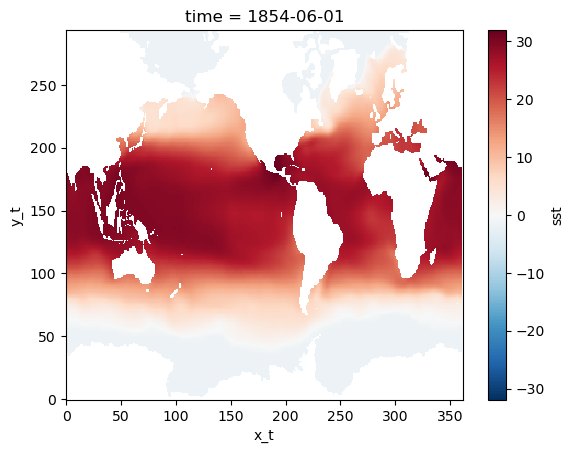

In [29]:
dfs_out['sst'].isel(time=5).plot()

## Write interpolated data dfs_out in a fileout

In [30]:
encoding = {'lat': {'_FillValue': -32767.0},
            'lon': {'_FillValue': -32767.0},
             varName: {'_FillValue': -32767.}
               }
dfs_out.to_netcdf(dir_out+fileout, unlimited_dims='time', encoding=encoding)

In [31]:
end = t.time()
print('Runtime to apply the weights to the data in filein is', '{0:.1f}'.format(end - begin), 's')

Runtime to apply the weights to the data in filein is 6.9 s
